# Imports

In [24]:
import pickle
import json
from parse_ara import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from soma_rabies_somadetector_data import brain2paths
from cloudreg.scripts.transform_points import NGLink
from cloudvolume import CloudVolume
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt 
from skimage import io, measure
import napari
import scipy.ndimage as ndi
from numpy import half
from sklearn.decomposition import PCA

# Bar charts

## Data

In [18]:
samples = {
    "8557": "tph2 vglut3",
    "8555": "tph2 vglut3",
    "8607": "tph2 gad2",
    "8606": "tph2 gad2",
    "8477": "gad2/vgat",
    "8531": "gad2/vgat",
    "8608": "tph2 gad2",
    "8529": "gad2/vgat",
    "8454": "gad2/vgat",
    "8446": "gad2/vgat",
}

regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]

counts = {}
for gene in set(samples.values()):
    count = 0
    for brain in samples.keys():
        if samples[brain] == gene:
            count += 1
    counts[gene] = count

quantification_dicts = {}
for sample in samples.keys():
    name = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/quantification_dict_"
        + sample
        + ".pickle"
    )
    with open(name, "rb") as handle:
        qdict = pickle.load(handle)
        quantification_dicts[sample] = qdict

no amygdala
http://atlas.brain-map.org/atlas?atlas=1&plate=100960360#atlas=1&plate=100960273&resolution=11.97&x=5804.000069754465&y=4358.8749912806925&zoom=-3&structure=703

## Setup atlas

In [19]:
# create vikram object
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

# create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

i_test = 2
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain] = G.nodes[key][brain] + quantification_dict[key]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain] = G.nodes[parent][brain] + G.nodes[node][brain]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

Max level: 10
0
45
11496


In [20]:
def dict2graph(quantification_dict):
    # create vikram object
    f = json.load(
        open(
            "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
            "r",
        )
    )

    tree = build_tree(f)
    stack = [tree]
    dfs_node_list = []  # node ids ordered by dfs
    reg_to_name = {}  # map from id to name

    while len(stack) > 0:
        node = stack.pop()

        if node.id in quantification_dict.keys():
            reg_to_name[node.id] = node.name
            dfs_node_list.append(node.id)

        if len(node.children) > 0:
            stack[0:0] = node.children

    quantification_dict_ordered = {}
    for id in dfs_node_list:
        if id not in quantification_dict.keys():
            continue
        try:
            roi_name = reg_to_name[id]
        except:
            roi_name = "Missing Name #" + str(id)
        quantification_dict_ordered[roi_name] = quantification_dict[id]

    for vol_key in quantification_dict.keys():
        if vol_key not in reg_to_name.keys():
            roi_name = "Unknown Name #" + str(vol_key)
            quantification_dict_ordered[roi_name] = quantification_dict[id]

    # create nx graph
    queue = [tree]
    cur_level = -1
    counter = 0
    G = nx.DiGraph()
    max_level = 0

    while len(queue) > 0:
        node = queue.pop(0)
        if node.level > max_level:
            max_level = node.level
        G.add_node(
            node.id,
            level=node.level,
            st_level=node.st_level,
            name=node.name,
            acronym=node.acronym,
            somas=0,
            label=str(node.st_level) + ") " + node.name,
        )
        if node.parent_id is not None:
            G.add_edge(node.parent_id, node.id)

        queue += node.children

    print(f"Max level: {max_level}")
    print(G.nodes[997]["somas"])
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key]["somas"] = G.nodes[key]["somas"] + quantification_dict[key]
    print(G.nodes[997]["somas"])

    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent]["somas"] = (
                    G.nodes[parent]["somas"] + G.nodes[node]["somas"]
                )
    print(G.nodes[997]["somas"])
    return G

## Collect data

In [21]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas = []
somas_pct = []
gene = []
subregion_name = []
region_name = []
brain_ids = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    # Determine region/subregion here*************
    children = list(G.successors(region))
    children = [region]

    for child in children:
        for brain in quantification_dicts.keys():
            somas.append(G.nodes[child][brain])
            somas_pct.append(G.nodes[child][brain] / totals[brain] * 100)

            gene.append(samples[brain] + f" (n={counts[samples[brain]]})")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])
            brain_ids.append(brain)

d = {
    "Somas (#)": somas,
    "Percent of Total Somas (%)": somas_pct,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
    "Brain ID": brain_ids
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


## Paper Figure

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hippocampal formation_tph2 vglut3 (n=2) vs. Hippocampal formation_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:4.099e-01 t=-9.553e-01
Claustrum_tph2 vglut3 (n=2) vs. Claustrum_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:1.570e-01 t=-1.878e+00
Striatum_tph2 vglut3 (n=2) vs. Striatum_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:3.468e-01 t=-1.113e+00
Pallidum_tph2 vglut3 (n=2) vs. Pallidum_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:3.982e-01 t=-9.827e-01
Cortical subplate_tph2 vglut3 (n=2) vs. Cortical subplate_tph2 gad2 (n=3): t-test independent samples with Benjamini-Yekutieli correction, P_val:2.384e-01 t=-1.468e+00
Hypothalamus_tph2 vglut

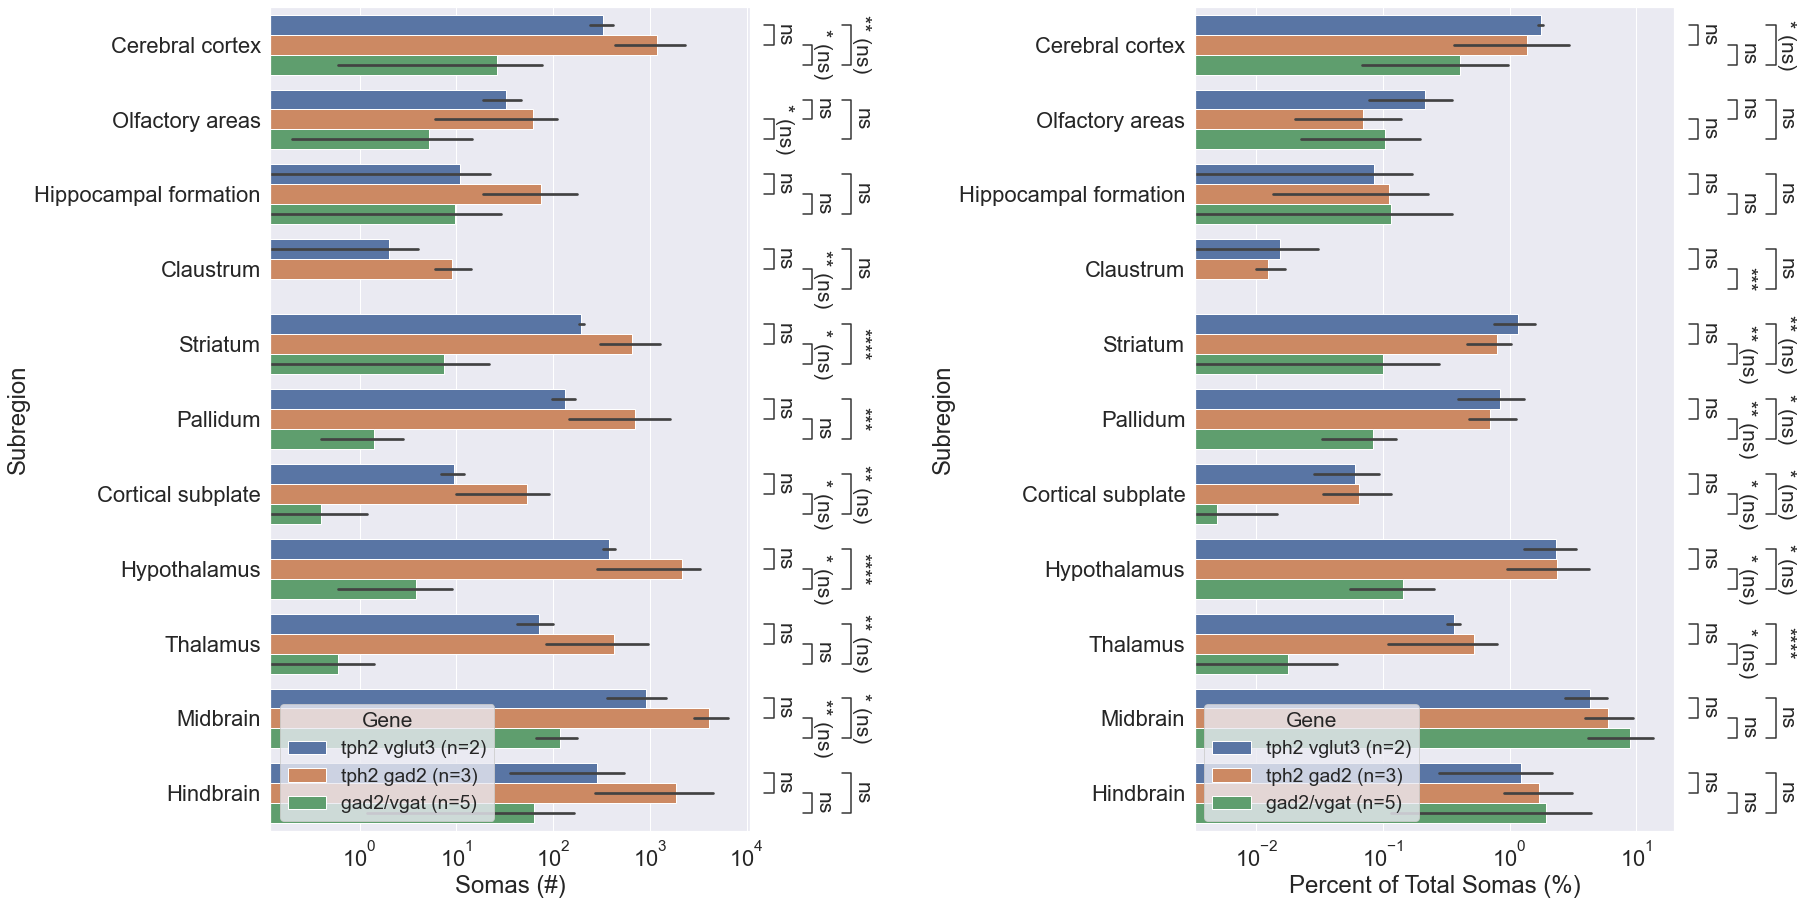

In [22]:
test = "Mann-Whitney" 
test = "t-test_ind"
correction = "fdr_by"

fig, axes = plt.subplots(1, 2, figsize=(26, 13))
sns.set(font_scale=1.75)

# soma counts
fig_args = {
    "y": "Somas (#)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}

pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a,b) for idx, a in enumerate(genes) for b in genes[idx+1:]]
for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Somas (#)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

bplot = sns.barplot(ax=axes[0], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(test=test, text_format="star", loc="outside", comparisons_correction=correction)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# distribution
fig_args = {
    "y": "Percent of Total Somas (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}

pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Percent of Total Somas (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

bplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
bplot.set_xscale("log")

annotator.configure(test=test, text_format="star", loc="outside", comparisons_correction=correction)
annotator.new_plot(bplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

## Compare distributions

In [23]:
df

,Somas (#),Percent of Total Somas (%),Gene,Subregion,Region,Brain ID
0,414,1.678424,tph2 vglut3 (n=2),Cerebral cortex,Cerebral cortex,8557
1,240,1.845586,tph2 vglut3 (n=2),Cerebral cortex,Cerebral cortex,8555
2,2316,2.970945,tph2 gad2 (n=3),Cerebral cortex,Cerebral cortex,8607
3,1093,0.772280,tph2 gad2 (n=3),Cerebral cortex,Cerebral cortex,8606
4,1,0.115741,gad2/vgat (n=5),Cerebral cortex,Cerebral cortex,8477
...,...,...,...,...,...,...
105,2,0.129534,gad2/vgat (n=5),Hindbrain,Hindbrain,8531
106,269,0.905998,tph2 gad2 (n=3),Hindbrain,Hindbrain,8608
107,2,0.227015,gad2/vgat (n=5),Hindbrain,Hindbrain,8529
108,0,0.000000,gad2/vgat (n=5),Hindbrain,Hindbrain,8454


8557
8555
8607
8606
8477
8531
8608
8529
8454
8446


Text(0.5, 1.0, 'Projection Distribution PCA with Explained Variance: [0.83687452 0.12763665]')

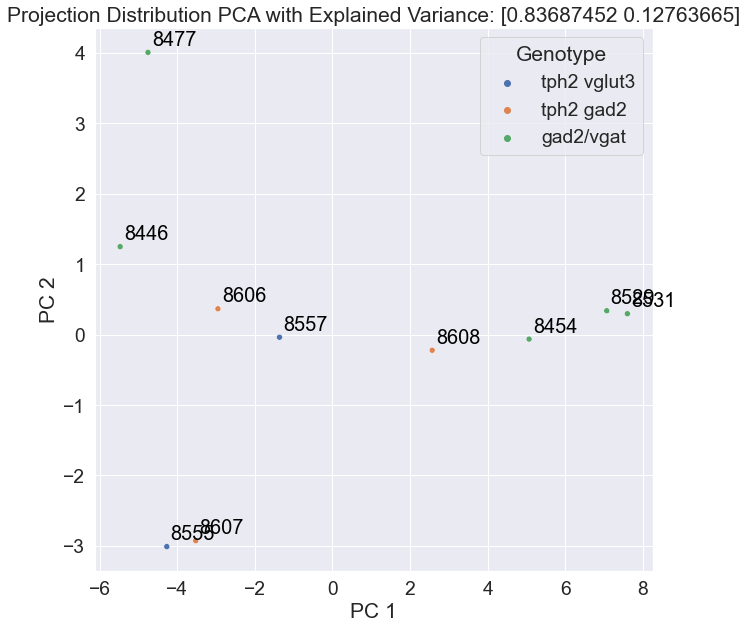

In [31]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(samples):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")
    
    distrib = list(df.loc[df["Brain ID"] == brain]["Percent of Total Somas (%)"])
    X.append(distrib)
    
    brain_ids.append(brain)
    genotypes.append(samples[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {"PC 1": X_2[:,0], "PC 2": X_2[:,1], "Genotype": genotypes, "Brain ID": brain_ids}
df_pca = pd.DataFrame(data = df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data = df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)

for i in range(df_pca.shape[0]):
    plt.text(x=df_pca["PC 1"][i]+0.1,y=df_pca["PC 2"][i]+0.1,s=df_pca['Brain ID'][i], 
        fontdict=dict(color='black',size=20))

plt.title(f"Projection Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}")

## Other plots

### scatter plot

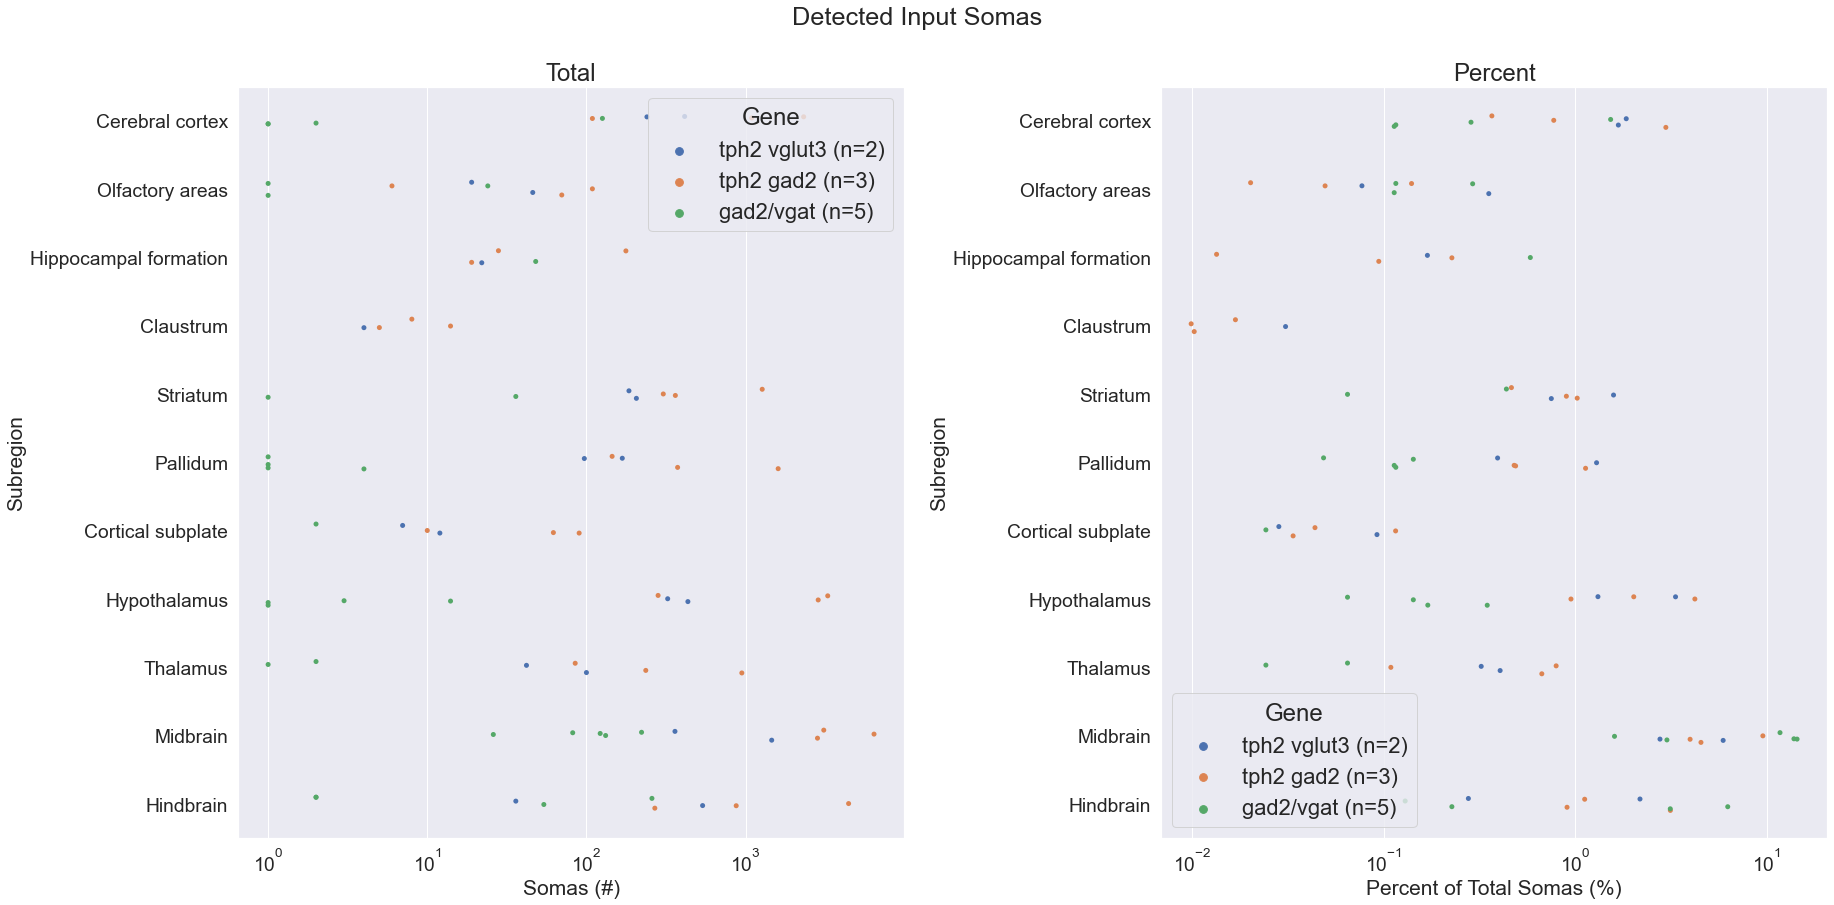

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(26, 13))
fig.suptitle("Detected Input Somas")
sns.set(font_scale=2)

sns.stripplot(ax=axes[0], x="Somas (#)", y="Subregion", hue="Gene", data=df)
axes[0].set_title("Total")
axes[0].set_xscale("log")

sns.stripplot(
    ax=axes[1], x="Percent of Total Somas (%)", y="Subregion", hue="Gene", data=df
)
axes[1].set_title("Percent")
axes[1].set_xscale("log")

fig.tight_layout()

### Difference

In [ ]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas_diff = []
somas_diff_sd = []
somas_pct_diff = []
somas_pct_diff_sd = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        vglut = []
        gad = []
        vglut_pct = []
        gad_pct = []
        for brain in quantification_dicts.keys():
            if brain in ["8557", "8555"]:
                vglut.append(G.nodes[child][brain])
                vglut_pct.append(G.nodes[child][brain] / totals[brain] * 100)
            else:
                gad.append(G.nodes[child][brain])
                gad_pct.append(G.nodes[child][brain] / totals[brain] * 100)

        somas_diff.append(np.mean(gad) - np.mean(vglut))
        somas_diff_sd.append(np.sqrt(np.var(vglut) + np.var(gad)))
        somas_pct_diff.append(np.mean(gad_pct) - np.mean(vglut_pct))
        somas_pct_diff_sd.append(np.sqrt(np.var(vglut_pct) + np.var(gad_pct)))

        subregion_name.append(G.nodes[child]["name"])
        region_name.append(G.nodes[region]["name"])

d = {
    "Somas Difference (#)": somas_diff,
    "soma sd": somas_diff_sd,
    "Percent of Total Somas Difference (%)": somas_pct_diff,
    "pct sd": somas_pct_diff_sd,
    "Subregion": subregion_name,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("VGlut: 2 samples, Gad: 1 sample")

sns.set(font_scale=1.3)

p = sns.barplot(
    ax=axes[0],
    x="Somas Difference (#)",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
axes[0].errorbar(
    x=df["Somas Difference (#)"],
    y=np.arange(df.shape[0]),
    xerr=df["soma sd"],
    fmt="None",
)
axes[0].set_title("Difference in Totals (Gad - VGlut)")

p = sns.barplot(
    ax=axes[1],
    x="Percent of Total Somas Difference (%)",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
axes[1].errorbar(
    x=df["Percent of Total Somas Difference (%)"],
    y=np.arange(df.shape[0]),
    xerr=df["pct sd"],
    fmt="None",
)
axes[1].set_title("Difference in Percent Total (Gad - VGlut)")

axes[0].legend(loc="center right")
axes[1].legend(loc="center right")

fig.tight_layout()

### Relative difference (coefficient of variation)

In [ ]:
import itertools

totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas_reldiff = []
somas_reldiff_sd = []
somas_pct_reldiff = []
somas_pct_reldiff_sd = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        vglut = []
        gad = []
        vglut_pct = []
        gad_pct = []
        for brain in quantification_dicts.keys():
            if brain in ["8557", "8555"]:
                vglut.append(G.nodes[child][brain])
                vglut_pct.append(G.nodes[child][brain] / totals[brain] * 100)
            else:
                gad.append(G.nodes[child][brain])
                gad_pct.append(G.nodes[child][brain] / totals[brain] * 100)

        if np.mean(vglut) == 0:
            reldiff = 0
        else:
            reldiff = (np.mean(gad) - np.mean(vglut)) / np.mean(vglut)

        combos = list(itertools.product(gad, vglut))

        sum = 0
        for combo in combos:
            if combo[1] == 0:
                sum = 0
                break
            else:
                sum += (combo[0] / combo[1] - 1) ** 2

        sum = sum / len(combos)

        somas_reldiff.append(reldiff)
        somas_reldiff_sd.append(sum)
        # pct
        if np.mean(vglut_pct) == 0:
            reldiff = 0
        else:
            reldiff = (np.mean(gad_pct) - np.mean(vglut_pct)) / np.mean(vglut_pct)

        combos = list(itertools.product(gad_pct, vglut_pct))

        sum = 0
        for combo in combos:
            if combo[1] == 0:
                sum = 0
                break
            else:
                sum += (combo[0] / combo[1] - 1) ** 2

        sum = sum / len(combos)

        somas_pct_reldiff.append(reldiff)
        somas_pct_reldiff_sd.append(sum)

        subregion_name.append(G.nodes[child]["name"])
        region_name.append(G.nodes[region]["name"])

d = {
    "Somas Relative Difference": somas_reldiff,
    "soma sd": somas_reldiff_sd,
    "Percent of Total Somas Relative Difference": somas_pct_reldiff,
    "pct sd": somas_pct_reldiff_sd,
    "Subregion": subregion_name,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("VGlut: 2 samples, Gad: 1 sample")

p = sns.barplot(
    ax=axes[0],
    x="Somas Relative Difference",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
# axes.errorbar(x = df["Somas Relative Difference"], y = np.arange(df.shape[0]),  xerr=df["soma sd"], fmt='None')
axes[0].set_title("Relative Difference in Totals (Gad - VGlut)/VGlut")

p = sns.barplot(
    ax=axes[1],
    x="Percent of Total Somas Relative Difference",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
# axes[1].errorbar(x = df["Percent of Total Somas Difference (%)"], y = np.arange(df.shape[0]),  xerr=df["pct sd"], fmt='None')
axes[1].set_title("Percent of Total Somas Relative Difference (Gad - VGlut)/VGlut")


fig.tight_layout()

## Make bar charts

In [ ]:
def get_bar_info(G, color_num=0):
    total = 0
    for node in G.nodes:
        total += G.nodes[node]["somas"]

    cmap = mpl.cm.get_cmap("tab20")

    y_pos = [0]
    width = []
    labels = []
    colors = []
    for r, region in enumerate(regions):

        print(f"Populating: " + G.nodes[region]["name"])
        names = []
        somas = []
        children = list(G.successors(region))
        n_entries = np.amax([len(children), 1])
        y_pos += list(np.arange(y_pos[-1] + 2, y_pos[-1] + n_entries + 2))
        if len(children) > 0:
            for child in children:
                labels.append(G.nodes[child]["name"])
                width.append(G.nodes[child]["somas"] / total * 100)
                colors.append(cmap(2 * r + color_num))
        else:
            labels.append(G.nodes[region]["name"])
            width.append(G.nodes[region]["somas"] / total * 100)
            colors.append(cmap(2 * r + color_num))

    y_pos = [-1 * y for y in y_pos]
    y_pos = np.array(y_pos[1:])
    return y_pos, width, labels, colors

In [ ]:
height = 0.4

fig, ax = plt.subplots(figsize=(10, 10))

y_pos, width, labels, colors = get_bar_info(G, 0)
ax.barh(
    y=y_pos, width=width, height=height, tick_label=labels, color=colors, label="8557"
)
y_pos, width, labels, colors = get_bar_info(G3, 1)
ax.barh(
    y=y_pos + height,
    width=width,
    height=height,
    tick_label=labels,
    color=colors,
    label="8607",
)

ax.legend()
ax.set_xlabel("Percent of total inputs (%)")

# Plot somas on atlas

In [2]:
def find_atlas_level_label(label, atlas_level_nodes, atlas_level, G):
    if label == 0 or label not in G.nodes or G.nodes[label]["st_level"] <= atlas_level:
        return label
    else:
        counter = 0
        # find which region of atlas_level is parent
        for atlas_level_node in atlas_level_nodes:
            if label in nx.algorithms.dag.descendants(G, source=atlas_level_node):
                counter += 1
                atlas_level_label = atlas_level_node
        if counter == 0:
            preds = list(G.predecessors(label))
            if len(preds) != 1:
                raise ValueError(f"{len(preds)} predecessors of node {label}")
            atlas_level_label = find_atlas_level_label(preds[0], atlas_level_nodes, atlas_level, G)
            counter += 1
        if counter != 1:
            raise ValueError(f"{counter} atlas level predecessors of {label}")
        return atlas_level_label

parcellation = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")

colors = {"tph2 vglut3": "blue", "tph2 gad2": "red", "gad2 vgat": "green"}

symbols = ["o", "+", "^", "vbar"]

atlas_points = {}

for key in tqdm(brain2paths.keys(), desc="Going through samples"):
    if "atlas_viz" in brain2paths[key].keys():
        viz_link = brain2paths[key]["atlas_viz"]
        viz_link = NGLink(viz_link.split("json_url=")[-1])
        ngl_json = viz_link._json
        for layer in ngl_json['layers']:
            if layer['type'] == 'annotation':
                points = []
                for annot in layer['annotations']:
                    points.append(annot['point'])
                
                atlas_points[key] = np.array(points)




Going through samples: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


In [3]:
atlas = io.imread(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif"
)

In [4]:
atlas_level = 5

atlas_level_nodes = []

for node in G.nodes:
    if G.nodes[node]["st_level"] == atlas_level:
        atlas_level_nodes.append(node)
        print(f"{node}: {G.nodes[node]['name']}")

NameError: name 'G' is not defined

### 2D

In [22]:
new_labels = {}
for z in np.arange(100, 1300, 100):
    slice = atlas[z, :, :]
    newslice = np.copy(slice)
    for label in tqdm(np.unique(slice), desc=f"Relabeling in z={z}"):
        atlas_level_label = find_atlas_level_label(label, atlas_level_nodes, atlas_level, G)
        newslice[slice == label] = atlas_level_label
        if atlas_level_label not in new_labels.keys():
            if atlas_level_label in G.nodes:
                name = G.nodes[atlas_level_label]["name"]
            else:
                name = "??"
            new_labels[atlas_level_label] = name

    print(new_labels)

    labels = measure.label(newslice)
    borders = 0 * labels
    for label in tqdm(np.unique(labels), desc=f"Processing labels in z={z}"):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    half_width = np.round(borders.shape[1]/2).astype(int)
    borders_hemi = borders[:,:half_width]
    newslice_hemi = newslice[:,:half_width]

    v = napari.Viewer()
    v.add_labels(newslice_hemi, scale = [10,10])
    v.add_image(borders_hemi, scale = [10,10], name=f"z={z}")
    

    gtype_counts = {"tph2 vglut3": 0, "tph2 gad2": 0, "gad2 vgat": 0}
    for key in tqdm(atlas_points.keys(), desc=f"Processing brains in z={z}"):
        ra = atlas_points[key]
        gtype = brain2paths[key]["genotype"]

        ra = atlas_points[key]
        points = ra[(ra[:,0] < z+10) & (ra[:,0] > z-10)]

        #only select points that fall on an ROI
        fg_points = []
        for point in points:
            im_coord = [int(point[1]), int(point[2])]

            if im_coord[0] in range(0, newslice.shape[0]) and im_coord[1] in range(0, newslice.shape[1]) and newslice[im_coord[0], im_coord[1]] != 0:
                if im_coord[1] >= half_width:
                    im_coord[1] = 2* half_width - im_coord[1]

                fg_points.append([im_coord[0], im_coord[1]])

        v.add_points(fg_points, symbol = symbols[gtype_counts[gtype]], face_color=colors[gtype], size=10, name=f"{key}: {gtype}", scale = [10,10]) 
        gtype_counts[gtype] = gtype_counts[gtype] + 1

    v.scale_bar.unit = "um"
    v.scale_bar.visible = True

Relabeling in z=100: 100%|██████████| 4/4 [00:00<00:00, 367.65it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves'}


Relabeling in z=200: 100%|██████████| 21/21 [00:00<00:00, 341.04it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex'}


Relabeling in z=300: 100%|██████████| 46/46 [00:00<00:00, 269.98it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??'}


Relabeling in z=400: 100%|██████████| 67/67 [00:00<00:00, 346.39it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation'}


Relabeling in z=500: 100%|██████████| 104/104 [00:00<00:00, 354.41it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??'}


Relabeling in z=600: 100%|██████████| 135/135 [00:00<00:00, 338.61it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??'}


Relabeling in z=700: 100%|██████████| 159/159 [00:00<00:00, 333.92it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??', 312782560: '??'}


Relabeling in z=800: 100%|██████████| 163/163 [00:00<00:00, 355.33it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??', 312782560: '??', 313: 'Midbrain', 312782592: '??', 484682464: '??', 549009216: '??', 563807424: '??', 589508416: '??', 599626944: '??', 606826624: '??', 606826688: '??'}


Relabeling in z=900: 100%|██████████| 124/124 [00:00<00:00, 381.08it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??', 312782560: '??', 313: 'Midbrain', 312782592: '??', 484682464: '??', 549009216: '??', 563807424: '??', 589508416: '??', 599626944: '??', 606826624: '??', 606826688: '??', 960: 'cerebellum related fiber tracts', 771: 'Pons', 512: 'Cerebellum', 312782656: '??', 607344832: '??'}


Relabeling in z=1000: 100%|██████████| 80/80 [00:00<00:00, 330.19it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??', 312782560: '??', 313: 'Midbrain', 312782592: '??', 484682464: '??', 549009216: '??', 563807424: '??', 589508416: '??', 599626944: '??', 606826624: '??', 606826688: '??', 960: 'cerebellum related fiber tracts', 771: 'Pons', 512: 'Cerebellum', 312782656: '??', 607344832: '??', 354: 'Medulla', 528: 'Cerebellar cortex'}


Relabeling in z=1100: 100%|██████████| 56/56 [00:00<00:00, 308.07it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??', 312782560: '??', 313: 'Midbrain', 312782592: '??', 484682464: '??', 549009216: '??', 563807424: '??', 589508416: '??', 599626944: '??', 606826624: '??', 606826688: '??', 960: 'cerebellum related fiber tracts', 771: 'Pons', 512: 'Cerebellum', 312782656: '??', 607344832: '??', 354: 'Medulla', 528: 'Cerebellar cortex', 519: 'Cerebellar nuclei'}


Relabeling in z=1200: 100%|██████████| 49/49 [00:00<00:00, 342.10it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 477: 'Striatum', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 991: 'medial forebrain bundle system', 997: 'root', 1089: 'Hippocampal formation', 1097: 'Hypothalamus', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 560581568: '??', 312782560: '??', 313: 'Midbrain', 312782592: '??', 484682464: '??', 549009216: '??', 563807424: '??', 589508416: '??', 599626944: '??', 606826624: '??', 606826688: '??', 960: 'cerebellum related fiber tracts', 771: 'Pons', 512: 'Cerebellum', 312782656: '??', 607344832: '??', 354: 'Medulla', 528: 'Cerebellar cortex', 519: 'Cerebellar nuclei'}


Processing brains in z=1200: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


### 3D

## Create data json

In [ ]:
def get_entry(node):
    entry = {"name": G.nodes[node]["name"]}
    successor_nodes = list(G.successors(node))
    somas = G.nodes[node]["somas"]

    if len(successor_nodes) > 0:
        children_somas = 0
        children = []
        for child in successor_nodes:
            children_somas += G.nodes[child]["somas"]
            child_entry = get_entry(child)
            if child_entry is not None:
                children.append(child_entry)
        if children_somas < somas:
            children.append({"name": "other", "value": somas - children_somas})
        entry["children"] = children
        return entry
    elif somas > 0:
        entry["value"] = somas
        return entry
    else:
        return

In [ ]:
import json

for node in G.nodes:
    if G.nodes[node]["level"] == 0:
        print(node)

In [ ]:
json_string = json.dumps(get_entry(997))
print(json_string)
with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/d3js/somas.json",
    "w",
    encoding="utf-8",
) as outfile:
    json.dump(get_entry(997), outfile, ensure_ascii=False, indent=4)

## create nested chart

In [ ]:
def sort_pairs(tosort, other):
    zipped_lists = zip(tosort, other)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [list(tuple) for tuple in tuples]
    return list1, list2

In [ ]:
acros_4 = []
acros_5 = []
acros_6 = []
somas_4 = []
somas_5 = []
somas_6 = []
none = []

for node in G.nodes:
    if G.nodes[node]["st_level"] == 3:
        if G.nodes[node]["somas"] > 0:
            acros_4.append(G.nodes[node]["name"])
            somas_4.append(G.nodes[node]["somas"])

            children = G.successors(node)
            child_somas_counter = 0
            child_somas = []
            child_names = []

            for child in children:
                if G.nodes[child]["somas"] > 5:
                    child_names.append(G.nodes[child]["name"])
                    child_somas.append(G.nodes[child]["somas"])
                    child_somas_counter += G.nodes[child]["somas"]

                    grandchildren = G.successors(child)
                    grandchild_somas_counter = 0
                    grandchild_somas = []
                    grandchild_names = []
                    for grandchild in grandchildren:
                        if G.nodes[grandchild]["somas"] > 5:
                            grandchild_names.append(G.nodes[grandchild]["name"])
                            grandchild_somas.append(G.nodes[grandchild]["somas"])
                            grandchild_somas_counter += G.nodes[grandchild]["somas"]

                    if grandchild_somas_counter > G.nodes[child]["somas"]:
                        raise ValueError()
                    elif grandchild_somas_counter < G.nodes[child]["somas"]:
                        diff = G.nodes[child]["somas"] - grandchild_somas_counter
                        grandchild_names.append("other")
                        grandchild_somas.append(diff)

                    grandchild_somas, grandchild_names = sort_pairs(
                        grandchild_somas, grandchild_names
                    )
                    somas_6.extend(grandchild_somas)
                    acros_6.extend(grandchild_names)

            if child_somas_counter > G.nodes[node]["somas"]:
                raise ValueError()
            elif child_somas_counter < G.nodes[node]["somas"]:
                diff = G.nodes[node]["somas"] - child_somas_counter
                child_names.append("other")
                child_somas.append(diff)

            # child_somas, child_names = sort_pairs(child_somas, child_names)
            somas_5.extend(child_somas)
            acros_5.extend(child_names)

        else:
            none.append(G.nodes[node]["name"])


fig, ax = plt.subplots()

width = 1
ax.pie(
    somas_4,
    radius=1,
    labels=acros_4,
    labeldistance=0.3,
    wedgeprops=dict(width=width, edgecolor="w"),
)

ax.pie(
    somas_5,
    radius=2,
    labels=acros_5,
    labeldistance=0.6,
    wedgeprops=dict(width=width, edgecolor="w"),
)

ax.pie(somas_6, radius=3, labels=acros_6, wedgeprops=dict(width=width, edgecolor="w"))

plt.title(
    f"Brain R1 - {np.sum(somas_4)} Total Somas \n Inner Ring = ARA Level 3",
    pad=220,
    fontdict={"fontsize": 20},
)

In [ ]:
acros_4 = []
acros_5 = []
somas_4 = []
somas_5 = []
none = []

for node in G.nodes:
    if G.nodes[node]["st_level"] == 5:
        if G.nodes[node]["somas"] > 0:
            acros_4.append(G.nodes[node]["name"])
            somas_4.append(G.nodes[node]["somas"])

            children = G.successors(node)
            child_somas_counter = 0
            child_somas = []
            child_names = []

            for child in children:
                if G.nodes[child]["somas"] > 5:
                    child_names.append(G.nodes[child]["name"])
                    child_somas.append(G.nodes[child]["somas"])
                    child_somas_counter += G.nodes[child]["somas"]

            if child_somas_counter > G.nodes[node]["somas"]:
                raise ValueError()
            elif child_somas_counter < G.nodes[node]["somas"]:
                diff = G.nodes[node]["somas"] - child_somas_counter
                child_names.append("other")
                child_somas.append(diff)

            child_somas, child_names = sort_pairs(child_somas, child_names)
            somas_5.extend(child_somas)
            acros_5.extend(child_names)

        else:
            none.append(G.nodes[node]["name"])


fig, ax = plt.subplots()

width = 2
ax.pie(
    somas_4,
    radius=width,
    labels=acros_4,
    labeldistance=0.5,
    wedgeprops=dict(width=width, edgecolor="w"),
)

ax.pie(
    somas_5,
    radius=2 * width,
    labels=acros_5,
    wedgeprops=dict(width=width, edgecolor="w"),
)


plt.title(
    f"Brain R1 - {np.sum(somas_4)} Total Somas \n Inner Ring = ARA Level 5",
    pad=320,
    fontdict={"fontsize": 20},
)

In [ ]:
acros = []
somas = []
none = []
lvl = 6

for node in G.nodes:
    if G.nodes[node]["st_level"] == lvl:
        if G.nodes[node]["somas"] > 0:
            acros.append(G.nodes[node]["name"])
            somas.append(G.nodes[node]["somas"])
        else:
            none.append(G.nodes[node]["name"])

volumes = np.multiply(somas, 6.7 / (1000**3))
plt.bar(acros, somas)
plt.ylabel("Soma Count", fontsize=20)
plt.xlabel("ARA region")
plt.title(f"Level {lvl}", fontsize=20)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)

fig = plt.gcf()
fig.set_size_inches(26, 5)
plt.show()

print(f"Areas with none detected: {none}")

In [ ]:
nodes = []
for n in G.nodes:
    if G.nodes[n]["st_level"] <= 5:
        nodes.append(n)
len(nodes)
G2 = G.subgraph(nodes)

In [ ]:
pos_dict = {}
label_dict = {}
for level in np.arange(12):
    counter = 0
    for n in G2.nodes:
        if G2.nodes[n]["st_level"] == level:
            pos_dict[n] = (100 * counter, 11 - level)
            counter += 1
            label_dict[n] = G2.nodes[n]["acronym"]

In [ ]:
nx.draw_networkx(G2, pos_dict, labels=label_dict, node_size=1000)

In [ ]:
net = Network(notebook=True)
net.from_nx(G2)
net.show("example.html")  # only works on jupyter nb

## View transformed coords

In [ ]:
import json
from cloudvolume import CloudVolume
from skimage import io
import numpy as np
from tqdm import tqdm
import napari
from skimage import measure
import scipy.ndimage as ndi
from napari_animation import AnimationWidget

In [ ]:
vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017",
    mip=0,
    parallel=1,
    progress=False,
)
new_res = vol.resolution
og_res = [3.72, 3.72, 4]
res_factor = [i / j * 1000 for i, j in zip(og_res, new_res)]
print(f"ARA Resolution: {new_res}nm")

with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r1.json"
) as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i * j) for i, j in zip(res_factor, entry["point"])]
    points.append(point)
points_r1 = np.array(points)

with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r2.json"
) as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i * j) for i, j in zip(res_factor, entry["point"])]
    points.append(point)
points_r2 = np.array(points)

with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r3.json"
) as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i * j) for i, j in zip(res_factor, entry["point"])]
    points.append(point)
points_r3 = np.array(points)


# atlas = np.zeros(vol.shape, dtype=vol.dtype)

In [ ]:
atlas = io.imread(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif"
)

In [ ]:
v = napari.Viewer()
# v.add_labels(atlas)
v.add_points(points_r1, face_color="red", size=5)
v.add_points(points_r2, face_color="orange", size=5)
v.add_points(points_r3, face_color="blue", size=5)
animation_widget = AnimationWidget(v)
v.window.add_dock_widget(animation_widget, area="right")

In [ ]:
for z in [380, 680, 980]:
    slice = atlas[z, :, :]
    labels = measure.label(slice)
    borders = 0 * labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    points_r12d = []
    for point in points_r1:
        if point[0] > z - 10 and point[0] < z + 10:
            points_r12d.append([point[1], point[2]])
    points_r22d = []
    for point in points_r2:
        if point[0] > z - 10 and point[0] < z + 10:
            points_r22d.append([point[1], point[2]])
    points_r32d = []
    for point in points_r3:
        if point[0] > z - 10 and point[0] < z + 10:
            points_r32d.append([point[1], point[2]])

    v = napari.Viewer()
    v.add_image(borders)
    v.add_points(points_r12d, face_color="red", size=10)
    v.add_points(points_r22d, face_color="orange", size=10)
    v.add_points(points_r32d, face_color="blue", size=10)

In [ ]:
v = napari.Viewer()
v.add_image(borders)
v.add_points(points_r12d, face_color="red", size=10)
v.add_points(points_r22d, face_color="orange", size=10)
v.add_points(points_r32d, face_color="blue", size=10)
animation_widget = AnimationWidget(v)
v.window.add_dock_widget(animation_widget, area="right")

### download atlas as chunks

In [ ]:
for i in tqdm(range(0, atlas.shape[2], 10)):
    atlas[:, :, i : i + 10, :] = vol[:, :, i : i + 10, :]

In [ ]:
# io.imsave("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif", atlas)

## Make plots

In [ ]:
atlas.shape

In [ ]:
np.amax(points_r1, axis=0)

In [ ]:
for z in [180, 430, 680, 1030, 1280]:
    slice = atlas[z, :, :]
    labels = measure.label(slice)
    borders = 0 * labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    plt.imshow(borders, cmap="gray")
    indices = np.logical_and((points_r1[:, 0] < z + 3), (points_r1[:, 0] > z - 3))
    plt.scatter(points_r1[indices, 2], points_r1[indices, 1], c="b", s=5)
    indices = np.logical_and((points_r3[:, 0] < z + 3), (points_r3[:, 0] > z - 3))
    plt.scatter(points_r3[indices, 2], points_r3[indices, 1], c="r", s=5)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig("/Users/thomasathey/Desktop/" + str(z) + ".png", dpi=100)

In [ ]:
a = np.zeros((10, 10, 10))
b = [[1.1, 1.1, 1.1], [2.1, 2.1, 2.1]]
v = napari.Viewer()
v.add_image(a)
v.add_points(b)